In [1]:
%matplotlib inline

import re
import os
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt


def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    
    bins = []
    for low in range(lower_bound, 
                     lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

In [2]:
cv2x_cross_roads_df = pd.read_csv("/home/brian/results-analysis/data/processed_data/2019-03-26_21:29-david-cross-roads-cv2x/vector.csv", usecols=["Node","Name", "Time", "Value"], dtype={"Node": "object", "Name": "object", "Time": "float", "Value": "float"})
cv2x_cross_roads_sca_df = pd.read_csv("/home/brian/results-analysis/data/processed_data/2019-03-26_21:29-david-cross-roads-cv2x/scalar.csv")
cv2x_highway_slow_df = pd.read_csv("/home/brian/results-analysis/data/processed_data/2019-03-26_22:48-david-highway-slow-cv2x/vector.csv", usecols=["Node","Name", "Time", "Value"], dtype={"Node": "object", "Name": "object", "Time": "float", "Value": "float"})
cv2x_highway_fast_df = pd.read_csv("/home/brian/results-analysis/data/processed_data/2019-03-26_23:23-david-highway-fast-cv2x/vector.csv", usecols=["Node","Name", "Time", "Value"], dtype={"Node": "object", "Name": "object", "Time": "float", "Value": "float"})
wifi_df = pd.read_csv("/home/brian/results-analysis/data/processed_data/2019-03-26_21:30-david-cross-roads-80211p/vector.csv", usecols=["Node","Name", "Time", "Value"], dtype={"Node": "object", "Name": "object", "Time": "float", "Value": "float"})

In [3]:
stats_we_want = ["numAirFramesWithSCIsReceivedSignal:vector", 
                 "numAirFramesWithTBsReceivedSignal:vector", 
                 "numSCIAndTBPairsSignal:vector",
                 "numAirFramesWithSCIsNotReceivedSignal:vector",
                 "numAirFramesWithTBsNotReceivedSignal:vector",
                 "distanceSignal:vector"]
pdr_cross_roads_df = cv2x_cross_roads_df[cv2x_cross_roads_df["Name"].isin(stats_we_want)]
pdr_highway_slow_df = cv2x_highway_slow_df[cv2x_highway_slow_df["Name"].isin(stats_we_want)]
pdr_highway_fast_df = cv2x_highway_fast_df[cv2x_highway_fast_df["Name"].isin(stats_we_want)]

In [4]:
pdr_cross_roads_df.head()

,Node,Time,Name,Value
107345,0,0.143,numAirFramesWithSCIsNotReceivedSignal:vector,1.0
107346,0,0.345,numAirFramesWithSCIsNotReceivedSignal:vector,2.0
107347,0,0.446,numAirFramesWithSCIsNotReceivedSignal:vector,3.0
107348,0,0.648,numAirFramesWithSCIsNotReceivedSignal:vector,4.0
107349,0,0.850,numAirFramesWithSCIsNotReceivedSignal:vector,5.0


In [5]:
pdr_cross_roads_df = pdr_cross_roads_df.pivot_table(index="Time",
                                                    columns="Name", 
                                                    values="Value", 
                                                    fill_value=0, 
                                                    aggfunc="sum")

pdr_highway_slow_df = pdr_highway_slow_df.pivot_table(index="Time",
                                                      columns="Name", 
                                                      values="Value", 
                                                      fill_value=0, 
                                                      aggfunc="sum")

pdr_highway_fast_df = pdr_highway_fast_df.pivot_table(index="Time",
                                                      columns="Name", 
                                                      values="Value", 
                                                      fill_value=0, 
                                                      aggfunc="sum")

In [6]:
pdr_cross_roads_df.head()

Name,distanceSignal:vector,numAirFramesWithSCIsNotReceivedSignal:vector,numAirFramesWithSCIsReceivedSignal:vector,numAirFramesWithTBsNotReceivedSignal:vector,numAirFramesWithTBsReceivedSignal:vector,numSCIAndTBPairsSignal:vector
Time,,,,,,
0.127,270.336993,0,1,0,1,1
0.143,270.336993,1,0,1,0,0
0.228,270.331626,0,2,0,2,2
0.244,270.331693,0,1,2,0,0
0.329,270.316188,0,3,0,3,3


In [171]:
pdr_cross_roads_df["PDR"] = (pdr_cross_roads_df["numAirFramesWithSCIsReceivedSignal:vector"]/(pdr_cross_roads_df["numAirFramesWithSCIsReceivedSignal:vector"] + pdr_cross_roads_df["numAirFramesWithSCIsNotReceivedSignal:vector"])) * 100
pdr_highway_slow_df["PDR"] = (pdr_highway_slow_df["numAirFramesWithSCIsReceivedSignal:vector"]/(pdr_highway_slow_df["numAirFramesWithSCIsReceivedSignal:vector"] + pdr_highway_slow_df["numAirFramesWithSCIsNotReceivedSignal:vector"])) * 100
pdr_highway_fast_df["PDR"] = (pdr_highway_fast_df["numAirFramesWithSCIsReceivedSignal:vector"]/(pdr_highway_fast_df["numAirFramesWithSCIsReceivedSignal:vector"] + pdr_highway_fast_df["numAirFramesWithSCIsNotReceivedSignal:vector"])) * 100

In [172]:
bins = create_bins(lower_bound=0, width=10, quantity=49)

In [173]:
distances = []
pdrs_highway_slow = []
pdrs_highway_fast = []
pdrs_cross_roads = []
for interval in bins:
    lower_b = interval[0]
    upper_b = interval[1]
    pdr_temp_cross   = pdr_cross_roads_df[(pdr_cross_roads_df["distanceSignal:vector"] >= lower_b) & (pdr_cross_roads_df["distanceSignal:vector"] < upper_b)]
    pdr_temp_highway = pdr_highway_slow_df[(pdr_highway_slow_df["distanceSignal:vector"] >= lower_b) & (pdr_highway_slow_df["distanceSignal:vector"] < upper_b)]
    pdr_temp_highway_fast = pdr_highway_fast_df[(pdr_highway_fast_df["distanceSignal:vector"] >= lower_b) & (pdr_highway_fast_df["distanceSignal:vector"] < upper_b)]
    pdrs_cross_roads.append(pdr_temp_cross["PDR"].mean())
    pdrs_highway_fast.append(pdr_temp_highway_fast["PDR"].mean())
    distances.append(upper_b)

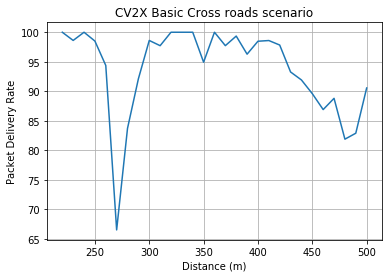

In [174]:
fig, ax = plt.subplots()
ax.plot(distances, pdrs_cross_roads)
ax.set(xlabel='Distance (m)', ylabel='Packet Delivery Rate',
       title='CV2X Basic Cross roads scenario')
ax.grid()

fig.savefig("cross-roads.png")
plt.show()